# Info

This script plots fluorescence spectroscopy data.

-----------------------
Created by Jerry LaRue, larue@chapman.edu, 12/2018

Last modified by Jerry LaRue, larue@chapman.edu, 11/2019

# Initialization

In [1]:
import ipywidgets as widgets
from ipywidgets import Button, Layout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import *
from IPython.display import clear_output
import csv
from os import listdir
from os.path import isfile, join
import re

##### Definitions #####

def FileList() :
    FileNames = [f for f in listdir(FolderPath.value) if isfile(join(FolderPath.value, f))]
    FileNames.append('None')
    return FileNames

def UpdateFileList(b) :
    FolderPath.value = FolderPath.value.replace('\\','/')
    FileName.options = FileList()

##### Select file #####

FolderPath = widgets.Text(
    value='../',
    placeholder='Type file path',
    description='Folder',
    layout=Layout(width='80%'),
    style = {'description_width': '150px'},
    disabled=False
)

FileName = widgets.Dropdown(
    options=FileList(),
    value='None',
    description='File',
    layout=Layout(width='80%'),
    style = {'description_width': '150px'},
    disabled=False,
)

button_UpdateFileList = widgets.Button(description="Update")
button_UpdateFileList.on_click(UpdateFileList)

display(widgets.Box([FolderPath,button_UpdateFileList]))
display(FileName)

Box(children=(Text(value='../', description='Folder', layout=Layout(width='80%'), placeholder='Type file path'…

Dropdown(description='File', index=1, layout=Layout(width='80%'), options=('Buffer Calculations.xlsx', 'None')…

# Plot data

In [14]:
%matplotlib inline

##### Load data #####

with open(FolderPath.value+"/"+FileName.value) as f:
    Content = f.readlines()
DataLength = list()
for index in range(len(Content)):
    DataLength.append(len(Content[index].split('\t')))
DataStart = list()
DataEnd = list()
Counter = 0
for index in range(len(DataLength)):
    if DataLength[index] == 1 :
        if Counter > 1 : DataEnd.append(index-1)
        Counter = 0
    else :
        if Counter == 0 : DataStart.append(index+3)
        Counter = Counter + 1
Header = list()
DataSets = 0
for index in range(len(DataStart)):
    DataSets = DataSets + DataLength[DataStart[index]]
Data = np.zeros((DataSets,DataEnd[0]-DataStart[0]+1))
for index in range(len(DataStart)):
    for x in range(DataLength[DataStart[index]]):
        Header.append(Content[DataStart[index]-2].split('\t')[x])
        for y in range(DataEnd[0]-DataStart[0]+1):
            if Content[DataStart[index]+y].split('\t')[x] != '' :
                Data[x + index * DataLength[DataStart[index-1]]][y] = Content[DataStart[index]+y].split('\t')[x]
for index in range(2,int(len(Data)/2)+1):
    Data = np.delete(Data,index,axis=0)
    Header.remove(Header[index-1])
Header.remove(Header[-1])
Header.insert(0,'X')
Data = pd.DataFrame(data=np.transpose(Data),columns=Header)
Names = Header.copy()
Names.remove(Names[0])
BackgroundNames = Names.copy()
BackgroundNames.insert(0,'None')

##### Definitions #####

def CreateSpectra() :
    if Background.value != 'None' :
        Buffer = Data[Background.value]
    i = 0
    Spectra = np.zeros((len(Runs_Selected.value)+1,len(Data[Data.columns[0]])))
    Spectra[0] = Data[Data.columns[0]]
    while i < len(Runs_Selected.value) :
        Spectra[i+1] = Data[Runs_Selected.value[i]]
        if Background.value != 'None' :
            Spectra[i+1] = Spectra[i+1] - Buffer
        i+=1
    return Spectra

def PlotData(Spectra) :
    plt.figure(figsize=(12,8))
    plt.xlabel('Wavelength (nm)',fontsize=16), plt.ylabel('Intensity (au)',fontsize=16)
    i = 0
    while i < Spectra.shape[0] - 1 :
        plt.plot(Spectra[0],Spectra[i+1],label=Runs_Selected.value[i])
        i+=1
    plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(1.4, 1), ncol=1, fontsize=16)
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    plt.show()

def Update_Runs_Clicked(b):
    with out:
        FilteredNames = [k for k in Names if Filter.value in k]
        Runs_Selected.options = FilteredNames
        FilteredNames.insert(0,'None')
        Background.options = FilteredNames

def SpectraToClipboard_Clicked(b):
    Spectra = CreateSpectra()
    DataHeader = list(Runs_Selected.value)
    DataHeader.insert(0,'X')
    DataToSave = pd.DataFrame(data=np.transpose(Spectra),columns=DataHeader)
    DataToSave.to_clipboard()

def Update_Plot_Clicked(b):
    with out:
        clear_output(True)
        Wavelength = np.zeros((0))
        Spectra = CreateSpectra()
        PlotData(Spectra)

##### Load data #####

Filter = widgets.Text(
    value='',
    placeholder='Type something',
    description='Filter:',
    disabled=False
)

Update_Runs = widgets.Button(description="Update run list")
Update_Runs.on_click(Update_Runs_Clicked)

SpectraToClipboard = widgets.Button(description="Copy selected data")
SpectraToClipboard.on_click(SpectraToClipboard_Clicked)

Background = widgets.Dropdown(
    options=BackgroundNames,
    value='None',
    layout=Layout(width='80%'),
    description='Select background run',
    style = {'description_width': '150px'},
    disabled=False,
)

if len(Names) < 20 :
    NumberRows = len(Names)
else :
    NumberRows = 20

Runs_Selected = widgets.SelectMultiple(
    options=Names,
    style = {'width': '100px','description_width': '150px'},
    rows=NumberRows,
    layout=Layout(width='80%'),
    description='Select runs',
    disabled=False
)

Update_Plot = widgets.Button(description="Update Plot")
Update_Plot.on_click(Update_Plot_Clicked)

display(widgets.Box([Filter,Update_Runs,SpectraToClipboard]))
display(Runs_Selected)
display(Background)
display(Update_Plot)
out = widgets.Output()
out

Box(children=(Text(value='', description='Filter:', placeholder='Type something'), Button(description='Update …

SelectMultiple(description='Select runs', layout=Layout(width='80%'), options=('Apo_buffer_0em_0ex', 'Apo_buff…

Dropdown(description='Select background run', layout=Layout(width='80%'), options=('None', 'Apo_buffer_0em_0ex…

Button(description='Update Plot', style=ButtonStyle())

Output()

***
# Fit data

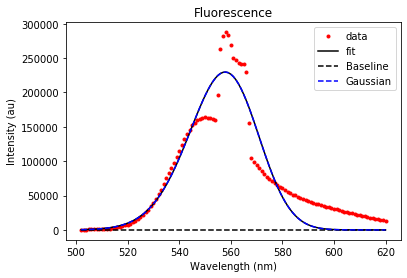

Skewed Gaussian | Amplitude: 7781982.4657, Center: 567.3, Width: 17.692, Skew: -1.291
_____________________________________________________________________________________


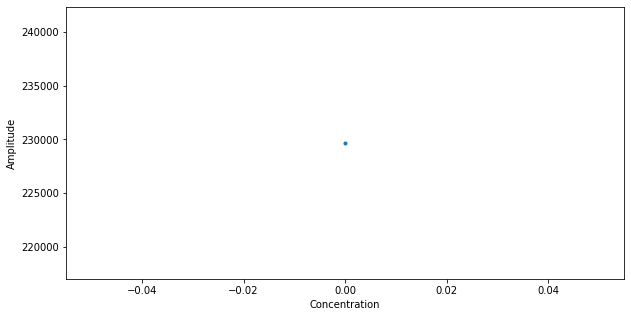

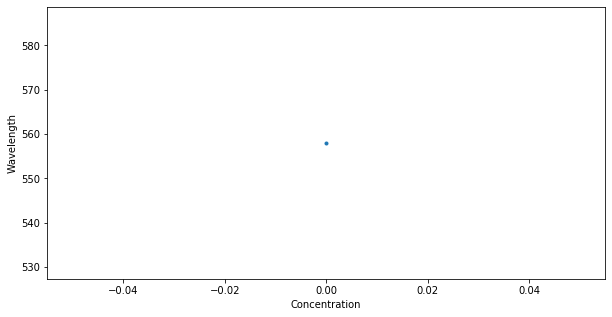

Button(description='Copy fit parameters', style=ButtonStyle())

In [4]:
###### Initialization #####

import lmfit
from lmfit import model
from lmfit.models import SkewedGaussianModel, GaussianModel, LinearModel, VoigtModel, PolynomialModel

##### Definitions #####

def FitsToClipboard_Clicked(b):
    DataHeader = list(('Concentration','Wavelength','Intensity (Max)','Intenisty (Norm)'))
    DataToSave = np.zeros((4,len(Wavelength)))
    DataToSave[0] = Concentration
    DataToSave[1] = Wavelength
    DataToSave[2] = Intensity
    DataToSave[3] = Intensity_Norm
    DataToSave = pd.DataFrame(data=np.transpose(DataToSave),columns=DataHeader)
    DataToSave['Name'] = Runs_Selected.value
    DataToSave.to_clipboard()

###### Load spectra #####

Spectra = CreateSpectra()

###### Setup arrays #####

B_Slope = list()
B_Intercept = list()
G_Amplitude = list()
G_Center = list()
G_Sigma = list()
G_Gamma = list()
Wavelength = list()
Intensity = list()
Intensity_Norm = list()

Concentration = np.zeros((len(Runs_Selected.value)))
i = 0
while i < len(Runs_Selected.value) :
    m = re.search(']_(.+?)uL_', Runs_Selected.value[i])
#     Concentration[i] = m.group(1)
    Concentration[i]
    i+=1

##### Determine reference fit function #####

Model = LinearModel(prefix='B_')
Model = Model + SkewedGaussianModel(prefix='G_')
Params = Model.make_params()

##### Define constraints #####

Params['B_slope'].value = 0
Params['B_slope'].vary = False
Params['B_intercept'].value = 0
Params['B_intercept'].vary = False
Params['G_amplitude'].value = 40000
Params['G_amplitude'].min = 0
Params['G_center'].value = 520
Params['G_sigma'].value = 43
Params['G_gamma'].value = 6

##### Fit data #####

i = 0
while i < Spectra.shape[0] - 1 :
    x = Spectra[0]
    y = Spectra[i+1]
    Fit = Model.fit(y, Params, x=x, fit_kws={'maxfev': 1000})
    Comps = Fit.eval_components(Fit.params, x=x)

    ##### Plot reference data and fits #####

    plt.plot(x, y,'r.', label='data')
    plt.plot(x, Fit.best_fit, 'k-', label='fit')
    plt.plot(x, Comps['B_'], 'k--', label='Baseline')
    plt.plot(x, Comps['G_'], 'b--', label='Gaussian')
    plt.legend(), plt.xlabel('Wavelength (nm)'), plt.ylabel('Intensity (au)')
    plt.title('Fluorescence')
    plt.show()
    print('Skewed Gaussian | Amplitude: ' + str(round(Fit.params['G_amplitude'].value,4)) + ', Center: ' + str(round(Fit.params['G_center'].value,1)) + ', Width: ' + str(round(Fit.params['G_sigma'].value,3)) + ', Skew: ' + str(round(Fit.params['G_gamma'].value,3)))
    B_Slope.append(Fit.params['B_slope'].value)
    B_Intercept.append(Fit.params['B_intercept'].value)
    G_Amplitude.append(Fit.params['G_amplitude'].value)
    G_Center.append(Fit.params['G_center'].value)
    G_Sigma.append(Fit.params['G_sigma'].value)
    G_Gamma.append(Fit.params['G_gamma'].value)
    Wavelength.append(x[np.argmax(Fit.best_fit)])
    Intensity.append(max(Fit.best_fit))
    Intensity_Norm.append(G_Amplitude[i]/G_Amplitude[0])
    i+=1
    
    print('_____________________________________________________________________________________')

plt.figure(figsize=(10,5))
plt.xlabel('Concentration'), plt.ylabel('Amplitude')
plt.plot(Concentration,Intensity,'.-')
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Concentration'), plt.ylabel('Wavelength')
plt.plot(Concentration,Wavelength,'.-')
plt.show()

FitsToClipboard = widgets.Button(description="Copy fit parameters")
FitsToClipboard.on_click(FitsToClipboard_Clicked)

display(FitsToClipboard)

***
# Calculate anisotropy

In [14]:
P0_I = np.array((Intensity))
P0_C = np.array((Concentration))

In [18]:
P90_I = np.array((Intensity))
P90_C = np.array((Concentration))

### Plot by concentration

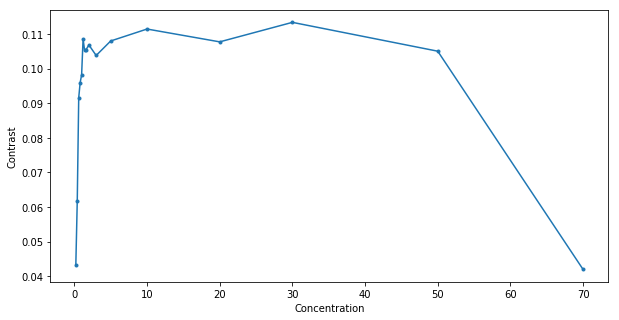

Button(description='Copy anisotropy data', style=ButtonStyle())

In [87]:
##### Definitions #####

def AnisotropyToClipboard_Clicked(b):
    DataHeader = list(('Concentration','Anisotropy'))
    DataToSave = np.zeros((2,len(Common_C)))
    DataToSave[0] = Common_C
    DataToSave[1] = Contrast
    DataToSave = pd.DataFrame(data=np.transpose(DataToSave),columns=DataHeader)
    DataToSave['Name'] = Runs_Selected.value
    DataToSave.to_clipboard()

##### Calculate anisotropy #####

Common = np.intersect1d(P0_C,P90_C,return_indices=True)
Common_C = Common[0]
P0_I_Common = P0_I[Common[1]]
P90_I_Common = P90_I[Common[2]]
Contrast = (P0_I_Common-P90_I_Common)/(P0_I_Common+2*P90_I_Common)

plt.figure(figsize=(10,5))
plt.xlabel('Concentration'), plt.ylabel('Contrast')
plt.plot(Common_C,Contrast,'.-')
plt.show()

AnisotropyToClipboard = widgets.Button(description="Copy anisotropy data")
AnisotropyToClipboard.on_click(AnisotropyToClipboard_Clicked)

display(AnisotropyToClipboard)

### Plot by run number

In [19]:
##### Definitions #####

def AnisotropyToClipboard_Clicked(b):
    DataHeader = list(('Anisotropy',))
    DataToSave = pd.DataFrame(data=np.transpose(Contrast),columns=DataHeader)
    DataToSave['Name'] = Runs_Selected.value
    DataToSave.to_clipboard()

##### Calculate anisotropy #####

Contrast = (P0_I-P90_I)/(P0_I+2*P90_I)
NumRuns = range(0,len(P0_I))
plt.figure(figsize=(10,5))
plt.xlabel('Run'), plt.ylabel('Contrast')
plt.plot(NumRuns,Contrast,'.-')
plt.show()

AnisotropyToClipboard = widgets.Button(description="Copy anisotropy data")
AnisotropyToClipboard.on_click(AnisotropyToClipboard_Clicked)

display(AnisotropyToClipboard)

ValueError: operands could not be broadcast together with shapes (17,) (10,) 

# Numerically integrate data

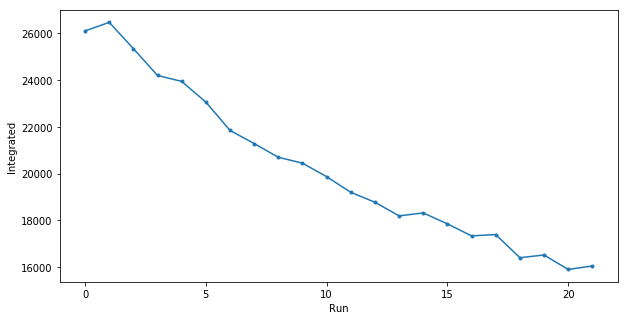

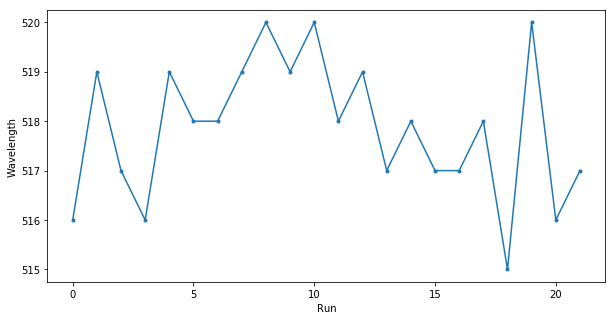

Button(description='Copy data', style=ButtonStyle())

In [5]:
%matplotlib inline


def NumIntToClipboard_Clicked(b):
    DataToSave = pd.DataFrame(data=np.transpose(TempData))
    DataToSave.to_clipboard()

Width = 9

Integrated = list()
Wavelength = list()
Spectra = CreateSpectra()
i = 0
while i < len(Runs_Selected.value) :
    x = Spectra[0]
    y = Spectra[i+1]
    Index = list(range(int(np.argmax(y)-Width),int(np.argmax(y)+Width+1)))
    Integrated.append(np.mean(y[Index]))
    Wavelength.append(x[np.argmax(y)])
    i+=1

TempData = np.zeros((2,len(Integrated)))
TempData[0] = Integrated
TempData[1] = Wavelength

plt.figure(figsize=(10,5))
plt.xlabel('Run'), plt.ylabel('Integrated')
plt.plot(Integrated,'.-')
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel('Run'), plt.ylabel('Wavelength')
plt.plot(Wavelength,'.-')
plt.show()


NumIntToClipboard = widgets.Button(description="Copy data")
NumIntToClipboard.on_click(NumIntToClipboard_Clicked)

display(NumIntToClipboard)

In [65]:
P0=Integrated

In [67]:
P90=Integrated

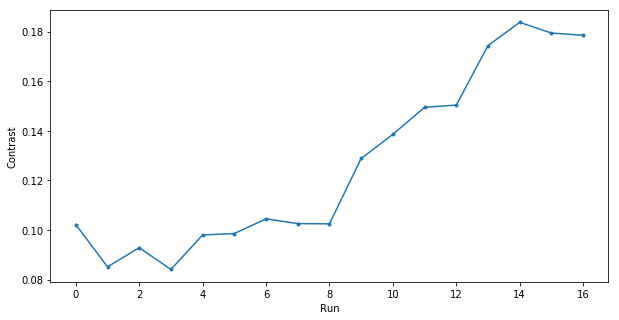

In [68]:
Contrast = list()
i = 0
while i < len(P0) :
    Contrast.append((P0[i]-P90[i])/(P0[i]+P90[i]))
    i+=1
plt.figure(figsize=(10,5))
plt.xlabel('Run'), plt.ylabel('Contrast')
plt.plot(Contrast,'.-')
plt.show()